-> AIM: Create a 3d model of the worm c.elegans from planar images of it
* Histogram equalise images (CLAHE)
* 3d median filter
* 

In [6]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io
from scipy.ndimage import median_filter
from scipy import signal

In [7]:
images = []
subfolder = 'testimages/2022.12.21_APS018_Infection_PA14-GacA_40X_40 _EM-4_D2_3_7047-1,2022.12.21_APS018_Infection_PA14[...]'
# sub = '2022.12.21_APS018_Infection_PA14-GacA_40X_40 _EM-4_D2_3_7047-'
for i in range(14): # number of tif layers
    address = subfolder + '/' + str(i+1) + '.jpg'
    img = skimage.io.imread(address)
    images.append(img)

In [8]:
# equalised_images = images

In [9]:
equalised_images = []
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))

for i in range(len(images)):
    img = clahe.apply(images[i])
    equalised_images.append(img)

In [10]:
equalised_images[0].dtype

dtype('uint8')

In [11]:
for eqimg in equalised_images:
    cv2.imshow('image', eqimg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
# med_blur_images = []
# for i in range(len(equalised_images)):
#     scaled_image = cv2.normalize(equalised_images[i], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     medimg = cv2.medianBlur(scaled_image, 3) # 21
#     med_blur_images.append(medimg)


In [13]:
eq_images = np.stack(equalised_images, axis=2)

In [14]:
eq_images.shape

(512, 512, 14)

In [15]:
med_blur_images_numpyarray = signal.medfilt(eq_images, kernel_size=(3,3,3))
med_blur_images = np.split(med_blur_images_numpyarray, med_blur_images_numpyarray.shape[2], axis=2)
med_blur_images = [np.squeeze(img) for img in med_blur_images]

In [16]:
# # from scipy import signal
# # import numpy as np

# # # Create a 3D array of random values
# # arr = np.random.rand(5, 5, 5)

# # # Apply a 3D median filter with a kernel size of 3 in each dimension
# # filtered_arr = signal.medfilt(arr, kernel_size=3)

# # Create a 3D numpy array
# arr_3d = np.random.rand(3, 3, 4)

# # Split the array along the third axis into multiple sub-arrays
# arrays = np.split(arr_3d, arr_3d.shape[2], axis=2)

# # Remove the singleton dimension from each sub-array
# arrays = [np.squeeze(arr) for arr in arrays]

# # Display the shape of the resulting arrays
# for arr in arrays:
#     print(arr.shape) # (3, 3)

In [17]:
# med_blur_images = []
# # kernel_size = (3, 3, 3)  # Adjust the kernel size as desired

# # for i in range(len(equalised_images)):
# #     medimg = np.copy(equalised_images[i])
# #     for channel in range(medimg.shape[2]):
# #         medimg[:, :, channel] = cv2.medianBlur(equalised_images[i][:, :, channel], kernel_size[0])
# #     med_blur_images.append(medimg)

# multi_channel_image = convert_to_multi_channel(equalised_images)

# # Apply median filtering to the multi-channel image
# kernel_size = (3, 3, 3)  # Adjust the kernel size as desired
# med_blur_image = medfilt3(multi_channel_image, kernel_size)

# # Separate the channels back into individual images
# med_blur_images = []
# for i in range(med_blur_image.shape[2]):
#     med_blur_images.append(med_blur_image[:, :, i])

# # Display the resulting images
# for i, image in enumerate(med_blur_images):
#     cv2.imshow(f"Median Blurred Image {i+1}", image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [18]:
for med_img in med_blur_images:
    cv2.imshow('image', med_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [19]:
binary_images = []
for med_img in med_blur_images:
    _, binary_image = cv2.threshold(med_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # _, binary_image = cv2.threshold(eqimg, 0, 255, cv2.THRESH_BINARY)
    binary_images.append(binary_image)


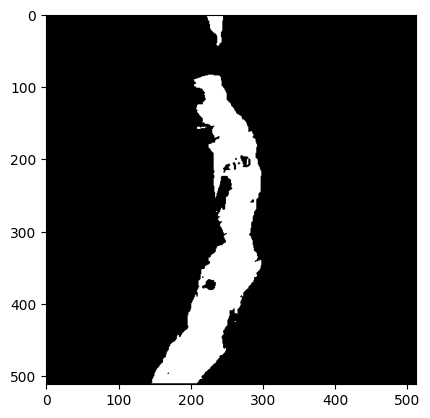

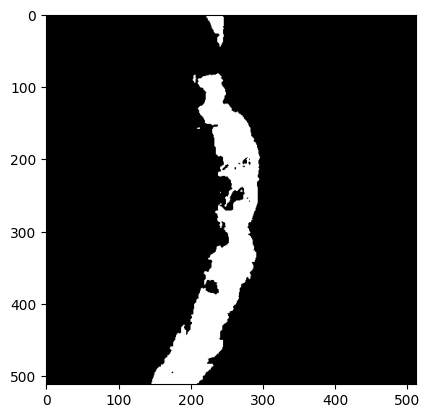

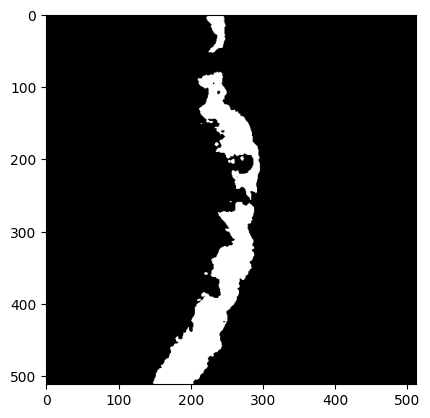

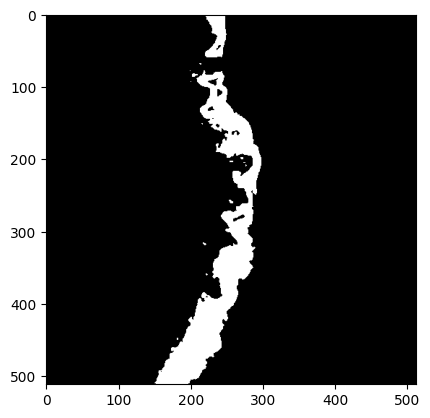

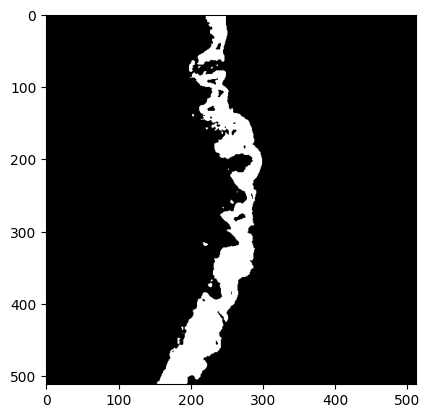

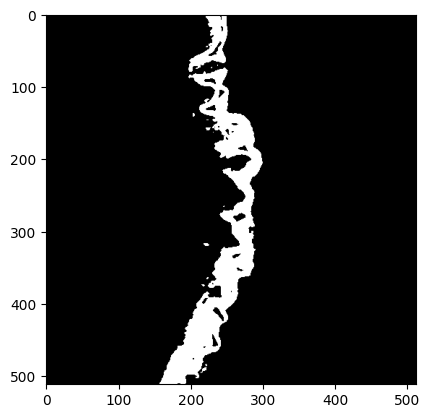

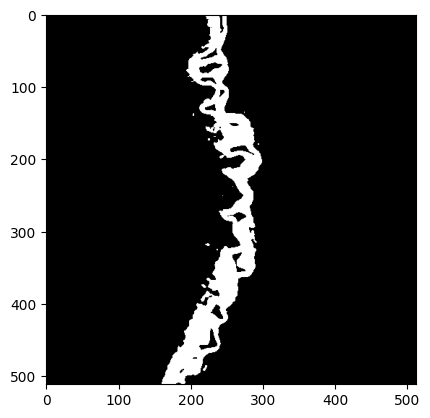

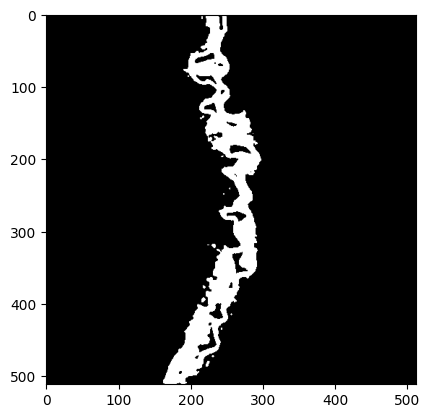

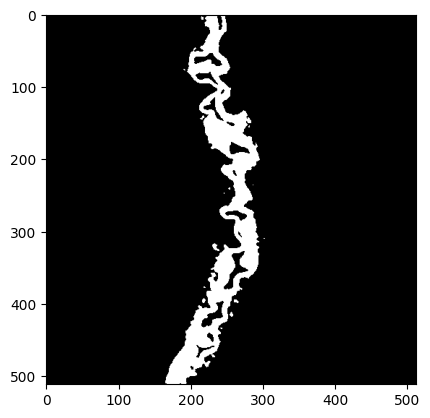

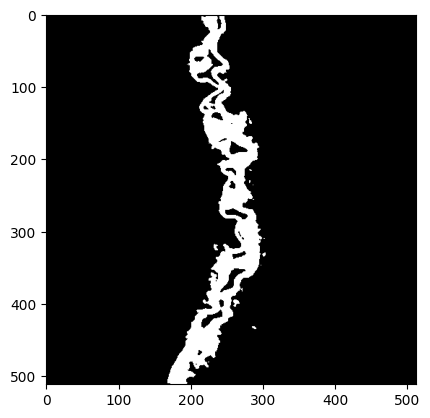

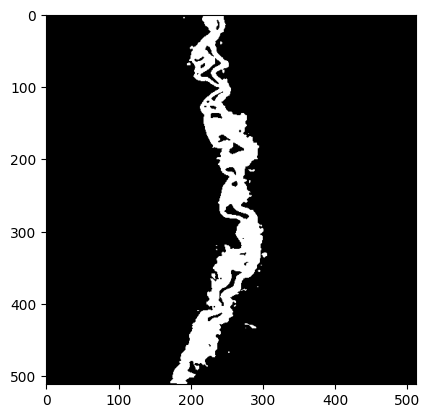

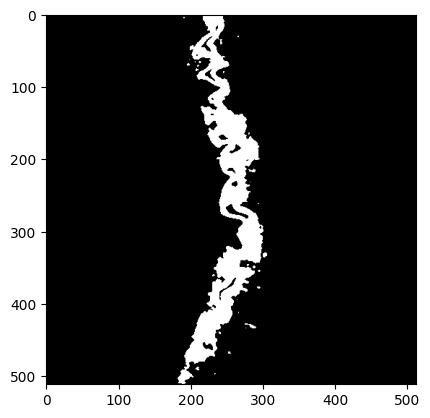

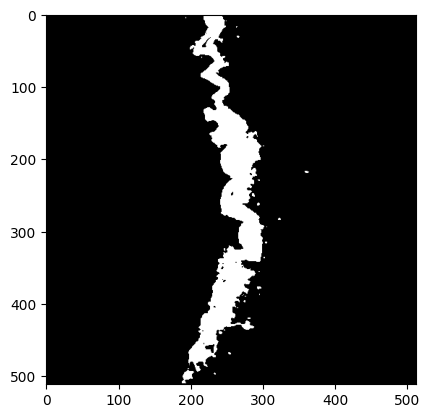

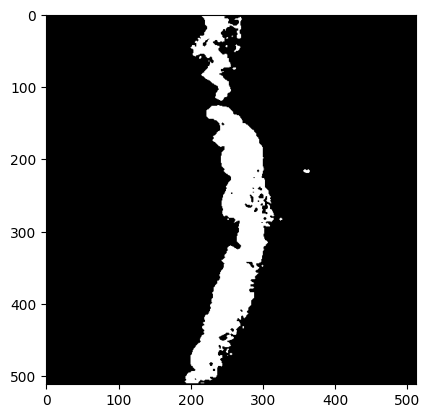

In [20]:
for bin_img in binary_images:
    plt.imshow(bin_img, cmap='gray')
    plt.show()

In [21]:
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

# Apply morphological closing operation to each binary image
closed_images = []
for binary_image in binary_images:
    closed_img = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    closed_images.append(closed_img)

In [22]:
# Extract pixel coordinates and map them to 3D space
coords = []
for i, image in enumerate(closed_images):
    coords_i = np.column_stack(np.where(image > 0))
    coords_i = np.hstack((coords_i, np.full((coords_i.shape[0], 1), -i)))  # Mapping to Z-coordinate
    coords.append(coords_i)

# Combine the pixel coordinates from all images
all_coords = np.concatenate(coords)

# Scale and normalize the coordinates
scale_factor_z = 3  # Adjust the scale factor for the z-axis as needed
all_coords[:, 2] = all_coords[:, 2] * scale_factor_z

# Calculate the center of the point cloud
center = np.mean(all_coords, axis=0)

# Translate the coordinates to center the point cloud
all_coords[:, 0] = all_coords[:, 0] - center[0]
all_coords[:, 1] = all_coords[:, 1] - center[1]
all_coords[:, 2] = all_coords[:, 2] - center[2]

# Create a point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(all_coords[:, [1, 0, 2]])  # Swap X and Y axes for Open3D

In [23]:
# Visualize the point cloud
downpcd = point_cloud.voxel_down_sample(voxel_size=0.01)

o3d.visualization.draw_geometries([point_cloud],
                                  zoom=1,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[0, 0, 0],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True,)


In [24]:
print(point_cloud)

PointCloud with 276357 points.


In [25]:
all_coords[:, [2, 1, 0]] = all_coords[:, [1, 0, 2]]  # Swap back X and Y axes
all_coords[:, 0] = all_coords[:, 0] + center[0]
all_coords[:, 1] = all_coords[:, 1] + center[1]
all_coords[:, 2] = all_coords[:, 2] + center[2]

inverse_scale_factor_z = 1 / scale_factor_z
all_coords[:, 2] = all_coords[:, 2] * inverse_scale_factor_z

layer_coords = {}
for coord in all_coords:
    z = coord[2]
    if z not in layer_coords:
        layer_coords[z] = []
    layer_coords[z].append(coord)

reconstructed_images = []
for z, layer in layer_coords.items():
    layer_coords_np = np.array(layer)
    layer_coords_np[:, [0, 1]] = layer_coords_np[:, [1, 0]]  # Swap X and Y axes
    layer_coords_np[:, 0] = layer_coords_np[:, 0] - np.min(layer_coords_np[:, 0])
    layer_coords_np[:, 1] = layer_coords_np[:, 1] - np.min(layer_coords_np[:, 1])
    image_shape = (np.max(layer_coords_np[:, 0]) + 1, np.max(layer_coords_np[:, 1]) + 1)
    binary_image = np.zeros(image_shape, dtype=np.uint8)
    binary_image[layer_coords_np[:, 0], layer_coords_np[:, 1]] = 255
    reconstructed_images.append(binary_image)

# Display the reconstructed images separately
# for i, image in enumerate(reconstructed_images):
#     plt.figure()
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')
#     plt.title(f"Reconstructed Image {i+1}")

#     plt.show()

In [26]:
# # Assume the code to reconstruct the point cloud and generate 'reconstructed_images' is present

# # Apply Convex Hull and display the results on separate images
# for i, image in enumerate(reconstructed_images):
#     # Find contours in the image
#     contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Create a blank image for displaying the convex hulls
#     convex_hull_image = np.zeros_like(image)

#     # Draw convex hulls on the image
#     for contour in contours:
#         hull = cv2.convexHull(contour)
#         cv2.drawContours(convex_hull_image, [hull], 0, 255, 2)

#     # # Display the original reconstructed image and the image with convex hulls side by side
#     # fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     # axes[0].imshow(image, cmap='gray')
#     # axes[0].axis('off')
#     # axes[0].set_title(f"Reconstructed Image {i+1}")
#     # axes[1].imshow(convex_hull_image, cmap='gray')
#     # axes[1].axis('off')
#     # axes[1].set_title(f"Convex Hulls on Image {i+1}")

#     # plt.tight_layout()
#     # plt.show()


In [27]:
# Assume the code to reconstruct the point cloud and generate 'reconstructed_images' is present

# Convert images with convex hulls back into a point cloud
coords = []
for i, image in enumerate(reconstructed_images):
    # Extract pixel coordinates
    coords_i = np.column_stack(np.where(image > 0))
    coords_i = np.hstack((coords_i, np.full((coords_i.shape[0], 1), -i)))  # Mapping to Z-coordinate
    coords.append(coords_i)

# Combine the pixel coordinates from all images
all_coords = np.concatenate(coords)

# Scale and normalize the coordinates
scale_factor_z = 1  # Adjust the scale factor for the z-axis as needed
all_coords[:, 2] = all_coords[:, 2] * scale_factor_z

# Calculate the center of the point cloud
center = np.mean(all_coords, axis=0)

# Translate the coordinates to center the point cloud
all_coords[:, 0] = all_coords[:, 0] - center[0]
all_coords[:, 1] = all_coords[:, 1] - center[1]
all_coords[:, 2] = all_coords[:, 2] - center[2]

# Create a point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(all_coords[:, [1, 0, 2]])  # Swap X and Y axes for Open3D

# Visualize the point cloud
downpcd = point_cloud.voxel_down_sample(voxel_size=0.01)

o3d.visualization.draw_geometries([point_cloud],
                                  zoom=1,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[0, 0, 0],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True)

In [ ]:
# # Assume the code to reconstruct the point cloud and generate 'reconstructed_images' is present

# # Detect circles using Hough Circle Transform and display them on separate images
# for i, image in enumerate(reconstructed_images):
#     # Apply Gaussian blur to reduce noise (adjust parameters as needed)
#     blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

#     # Apply Hough Circle Transform (adjust parameters as needed)
#     circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp=1, minDist=30,
#                                param1=50, param2=30, minRadius=5, maxRadius=20)

#     # Create a blank image for displaying the circles
#     circle_image = np.zeros_like(image)

#     # Draw detected circles on the circle image
#     if circles is not None:
#         circles = np.uint16(np.around(circles))
#         for circle in circles[0, :]:
#             center = (circle[0], circle[1])
#             radius = circle[2]
#             cv2.circle(circle_image, center, radius, 255, 2)

#     # Display the original reconstructed image and the circle image side by side
#     fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     axes[0].imshow(image, cmap='gray')
#     axes[0].axis('off')
#     axes[0].set_title(f"Reconstructed Image {i+1}")
#     axes[1].imshow(circle_image, cmap='gray')
#     axes[1].axis('off')
#     axes[1].set_title(f"Hough Circles on Image {i+1}")

#     plt.tight_layout()
#     plt.show()
